### Task 1

1. Implement batch gradient descent optimizer function  Take the dataset of Titanic  
2. Initialize a neural network with random weights. 
3. Calculate output of Neural Network: 
4. Calculate squared error loss 
5. Update network parameter using batch gradient descent optimizer function Implementation. 
6. Display updated weight and bias values 
7. Plot loss w.r.t. Iterations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load Titanic dataset
titanic = pd.read_csv('/media/smayan/500GB SSD/Study/ML2/Practicals/Data/titanic.csv')

# Preprocessing
# Select relevant features and handle missing values
# Adjust column names based on actual CSV (common Titanic datasets use 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived')
df = titanic.copy()

# Standardize column names to lowercase for consistency
df.columns = df.columns.str.lower()

# Select relevant features - use actual column names from the dataset
feature_cols = ['pclass', 'sex', 'age', 'siblings/spouses aboard', 'parents/children aboard', 'fare']
target_col = 'survived'

# Keep only necessary columns
df = df[feature_cols + [target_col]].copy()

# Handle missing values
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)
df.dropna(inplace=True)

# Encode categorical variable
df['sex'] = df['sex'].map({'male': 0, 'female': 1, 'Male': 0, 'Female': 1})

# Separate features and target
X = df[feature_cols].values
y = df[target_col].values.reshape(-1, 1)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Features: {feature_cols}")

Dataset shape: X=(887, 6), y=(887, 1)
Features: ['pclass', 'sex', 'age', 'siblings/spouses aboard', 'parents/children aboard', 'fare']


/tmp/ipykernel_192595/1743091619.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/tmp/ipykernel_192595/1743091619.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [2]:
# 2. Initialize a neural network with random weights
input_size = X.shape[1]  # 6 features
hidden_size = 4
output_size = 1  # Binary classification (survived or not)

np.random.seed(42)

# Initialize weights and biases
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

print("Initial Weights and Biases:")
print(f"W1 shape: {W1.shape}")
print(f"b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape}")
print(f"b2 shape: {b2.shape}")

Initial Weights and Biases:
W1 shape: (6, 4)
b1 shape: (1, 4)
W2 shape: (4, 1)
b2 shape: (1, 1)


In [3]:
# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(a):
    return a * (1 - a)

# 3. Forward pass - Calculate output of Neural Network
def forward_propagation(X, W1, b1, W2, b2):
    """
    Perform forward propagation through the network
    Returns: output predictions and intermediate values for backprop
    """
    # Hidden layer
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    
    # Output layer
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    
    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return A2, cache

In [4]:
# 4. Calculate squared error loss
def compute_loss(y_true, y_pred):
    """
    Compute mean squared error loss
    """
    m = y_true.shape[0]
    loss = (1 / (2 * m)) * np.sum((y_pred - y_true) ** 2)
    return loss

# Backward propagation
def backward_propagation(X, y, cache, W1, W2):
    """
    Compute gradients using backpropagation
    """
    m = X.shape[0]
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Output layer gradients
    dZ2 = (A2 - y) * sigmoid_derivative(A2)
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
    
    # Hidden layer gradients
    dZ1 = np.dot(dZ2, W2.T) * sigmoid_derivative(A1)
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)
    
    gradients = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return gradients

In [5]:
# 5. Implement Batch Gradient Descent Optimizer with Momentum
def batch_gradient_descent(X, y, W1, b1, W2, b2, learning_rate=0.01, iterations=1000, momentum=0.0):
    """
    Batch Gradient Descent Optimizer with Momentum
    Updates weights using gradients computed on the entire dataset
    
    Parameters:
    - momentum: momentum coefficient (0 = no momentum, typically 0.9)
    """
    loss_history = []
    
    # Initialize velocity terms for momentum
    vW1 = np.zeros_like(W1)
    vb1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2)
    vb2 = np.zeros_like(b2)
    
    for i in range(iterations):
        # Forward propagation
        y_pred, cache = forward_propagation(X, W1, b1, W2, b2)
        
        # Compute loss
        loss = compute_loss(y, y_pred)
        loss_history.append(loss)
        
        # Backward propagation
        gradients = backward_propagation(X, y, cache, W1, W2)
        
        # Update velocities with momentum
        vW1 = momentum * vW1 + (1-momentum) * learning_rate * gradients['dW1']
        vb1 = momentum * vb1 + (1-momentum) * learning_rate * gradients['db1']
        vW2 = momentum * vW2 + (1-momentum) * learning_rate * gradients['dW2']
        vb2 = momentum * vb2 + (1-momentum) * learning_rate * gradients['db2']
        
        # Update parameters using velocity
        W1 = W1 - vW1
        b1 = b1 - vb1
        W2 = W2 - vW2
        b2 = b2 - vb2
        
        # Print progress every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Iteration {i+1}/{iterations}, Loss: {loss:.4f}")
    
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return parameters, loss_history

# Train the network
print("Training Neural Network with Batch Gradient Descent...")
print("="*60)
parameters, loss_history = batch_gradient_descent(
    X, y, W1, b1, W2, b2, 
    learning_rate=0.5, 
    iterations=1000,
    momentum=0.9
)

Training Neural Network with Batch Gradient Descent...
Iteration 100/1000, Loss: 0.1175
Iteration 200/1000, Loss: 0.1145
Iteration 300/1000, Loss: 0.1067
Iteration 400/1000, Loss: 0.0942
Iteration 500/1000, Loss: 0.0837
Iteration 600/1000, Loss: 0.0780
Iteration 700/1000, Loss: 0.0751
Iteration 800/1000, Loss: 0.0735
Iteration 900/1000, Loss: 0.0725
Iteration 1000/1000, Loss: 0.0719


In [6]:
# 6. Display updated weight and bias values
print("\n" + "="*60)
print("UPDATED WEIGHTS AND BIASES AFTER TRAINING")
print("="*60)

print("\nLayer 1 (Input -> Hidden):")
print(f"W1 (shape {parameters['W1'].shape}):")
print(parameters['W1'])
print(f"\nb1 (shape {parameters['b1'].shape}):")
print(parameters['b1'])

print("\nLayer 2 (Hidden -> Output):")
print(f"W2 (shape {parameters['W2'].shape}):")
print(parameters['W2'])
print(f"\nb2 (shape {parameters['b2'].shape}):")
print(parameters['b2'])

print("\n" + "="*60)
print(f"Final Loss: {loss_history[-1]:.4f}")
print(f"Initial Loss: {loss_history[0]:.4f}")
print(f"Loss Reduction: {loss_history[0] - loss_history[-1]:.4f}")
print("="*60)


UPDATED WEIGHTS AND BIASES AFTER TRAINING

Layer 1 (Input -> Hidden):
W1 (shape (6, 4)):
[[ 0.69950357  0.66294884  0.68142935  0.69198676]
 [-1.09974381 -1.04589364 -1.0509746  -1.06117579]
 [ 0.40781088  0.38332246  0.38422636  0.39143606]
 [ 0.31408378  0.2721496   0.28220892  0.29990137]
 [ 0.08592423  0.08911212  0.07754505  0.07745004]
 [-0.18397521 -0.19922252 -0.20039973 -0.20825874]]

b1 (shape (1, 4)):
[[-0.00080815 -0.01965122 -0.01563361 -0.01166341]]

Layer 2 (Hidden -> Output):
W2 (shape (4, 1)):
[[-1.28403791]
 [-1.17514227]
 [-1.19913486]
 [-1.22908447]]

b2 (shape (1, 1)):
[[1.80390387]]

Final Loss: 0.0719
Initial Loss: 0.1248
Loss Reduction: 0.0530


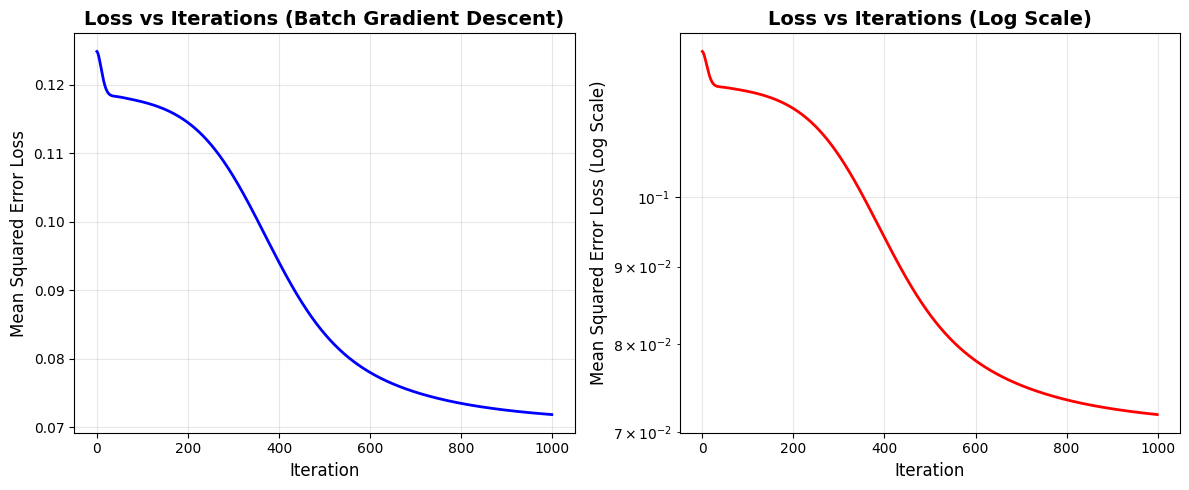


Final Model Accuracy: 79.93%


In [7]:
# 7. Plot loss w.r.t. Iterations
plt.figure(figsize=(12, 5))

# Plot 1: Loss over all iterations
plt.subplot(1, 2, 1)
plt.plot(loss_history, linewidth=2, color='blue')
plt.title('Loss vs Iterations (Batch Gradient Descent)', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Squared Error Loss', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot 2: Loss over iterations (log scale for better visualization)
plt.subplot(1, 2, 2)
plt.plot(loss_history, linewidth=2, color='red')
plt.title('Loss vs Iterations (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Squared Error Loss (Log Scale)', fontsize=12)
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate accuracy
final_predictions, _ = forward_propagation(X, parameters['W1'], parameters['b1'], 
                                          parameters['W2'], parameters['b2'])
predicted_classes = (final_predictions > 0.5).astype(int)
accuracy = np.mean(predicted_classes == y) * 100

print(f"\nFinal Model Accuracy: {accuracy:.2f}%")

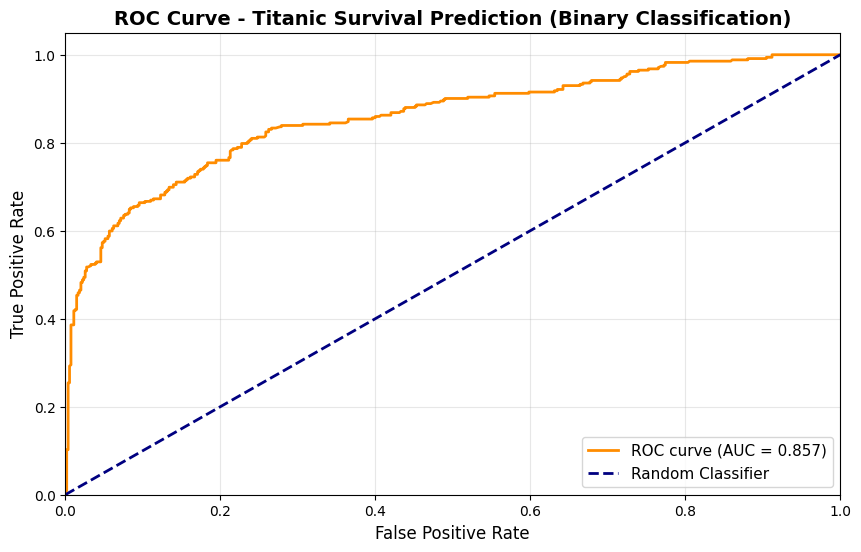


ROC AUC Score: 0.8570
Model Performance: Good


In [8]:

# Plot ROC AUC Curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get probability predictions
y_pred_proba, _ = forward_propagation(X, parameters['W1'], parameters['b1'], 
                                      parameters['W2'], parameters['b2'])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Titanic Survival Prediction (Binary Classification)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")
print(f"Model Performance: {'Excellent' if roc_auc >= 0.9 else 'Good' if roc_auc >= 0.8 else 'Fair' if roc_auc >= 0.7 else 'Poor'}")
